In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import nibabel as nb
import hrf_tools
import hcp_utils as hcp
from analysis import plot_results

import matplotlib.pyplot as plt

/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [12]:
import numpy as np
import nibabel as nb
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from nilearn_plotting_custom import plot_surf
from PIL import Image
from PIL import ImageDraw
import npp
import hcp_utils as hcp
from hcp_tools import load_flatmaps_59k
from hcp_tools import load_meshes
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
sns.set("paper", "white")
#%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

def plot_results(scores,score_type,data_type,vertex_info,subject,feature,dataset,title):
    '''Inputs:
        scores = data to plot
        score_type = r2, r, p, z, d, raw
        data_type = 32k (3T) or 59k (7T)
        vertex info = None or the vertex info if it is 59k data beacuse hcp_utils doesnt by default
        subject = eg 100610 subject id for file naming
        feature = eg as_scores plotted feature for file naming
        dataset = eg merlin or HCP_7T which dataset?
        title = 
    '''
    scratch_dir = '../tmp'
#     scratch_dir = '/scratch/scratch/Fri/jsmentch/tmp'
#     if not os.path.exists(scratch_dir):
#         os.mkdir(scratch_dir)
    if score_type == 'r2':
        v=[0,0.5]
        threshold=None
        symmetric_cmap=False
        cmap='inferno'
    if score_type == 'r':
        v=[0,1]
        threshold=None
        symmetric_cmap=False
        cmap='inferno'
    if score_type == 'p':
        v=[0,0.05]
        symmetric_cmap=False
        cmap='inferno'
    if score_type == 'z':
        v=[-10,10]
        threshold=6
        symmetric_cmap=True
        cmap='cold_hot'
    if score_type == 'd':
        v=[0,10]
        threshold=3
        symmetric_cmap=True
        cmap='inferno'
    if score_type == 'raw':
        v=[-10,10]
        threshold=1
        symmetric_cmap=True
        cmap='cold_hot'
    save_dir=f'../outputs/figures/{dataset}/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)    
    if data_type == '59k':
        flatmeshes=load_flatmaps_59k() #load flatmaps
        surf_path_msm = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.L.inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'
        mesh59k_msm = load_meshes(example_filename=surf_path_msm) #load other meshes
        # get data from results in plotting format
        score_cortex_dataL = hcp.left_cortex_data(scores, fill=0, vertex_info=vertex_info)
        score_cortex_dataR = hcp.right_cortex_data(scores, fill=0, vertex_info=vertex_info)
        # sulcal depth paths
        sulc_left = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.L.sulc.59k_fs_LR.shape.gii'
        sulc_right = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.R.sulc.59k_fs_LR.shape.gii'
        # params for view to plot
        params = [('flat_L',score_cortex_dataL,flatmeshes.flat_left,sulc_left,'left'),\
         ('flat_R',score_cortex_dataR,flatmeshes.flat_right,sulc_right,'right'),\
         ('vinf_L',score_cortex_dataL,mesh59k_msm.very_inflated_left,sulc_left,'left'),\
         ('vinf_R',score_cortex_dataR,mesh59k_msm.very_inflated_right,sulc_right,'right'),\
        ]
    elif data_type == '32k':
        score_cortex_dataL = hcp.left_cortex_data(scores, fill=0)
        score_cortex_dataR = hcp.right_cortex_data(scores, fill=0)
    #     # sulcal depth paths
    #     sulc_left = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.L.sulc.59k_fs_LR.shape.gii'
    #     sulc_right = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.R.sulc.59k_fs_LR.shape.gii'
    #     # params for view to plot
        params = [('flat_L',score_cortex_dataL,hcp.mesh.flat_left,hcp.mesh.sulc_left,'left'),\
         ('flat_R',score_cortex_dataR,hcp.mesh.flat_right,hcp.mesh.sulc_right,'right'),\
         ('vinf_L',score_cortex_dataL,hcp.mesh.very_inflated_left,hcp.mesh.sulc_left,'left'),\
         ('vinf_R',score_cortex_dataR,hcp.mesh.very_inflated_right,hcp.mesh.sulc_right,'right'),\
        ]
    # plot each hemi and mesh, save to outputs dir
    for name, data, mesh, sulc, hemi in params:
        #figure, axes = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(6,4))
        plot_surf(mesh,\
                data, \
                  cmap=cmap,symmetric_cmap=symmetric_cmap, avg_method='median',#figure=fig,\
                bg_map=sulc, colorbar=True, vmin=v[0], vmax=v[1], threshold=threshold, hemi=hemi, \
#                data_alpha=np.where(data>0,1,0),\
                data_alpha=np.ones(data.shape),\
                  data_remove=np.zeros(data.shape),output_file=f'{scratch_dir}/{name}.png')
#combine saved maps into one with PIL
#     if notebook==True:
    area = (75, 140, 635, 560) #area to crop from each image
#     else:
#         area = (105, 190, 880, 780)
        
    img = Image.open(f'{scratch_dir}/flat_L.png',mode='r')
    img = img.resize((770,720))
    cropped = img.crop(area)
    fL=cropped.transpose(Image.FLIP_LEFT_RIGHT)
    w,h = img.size
    c_area = (690, 0, w-10, h) # area of colorbar to crop
    cbar = img.crop(c_area)

    img = Image.open(f'{scratch_dir}/flat_R.png',mode='r')
    img = img.resize((770,720))
    fR = img.crop(area)

    img = Image.open(f'{scratch_dir}/vinf_L.png',mode='r')
    img = img.resize((770,720))
    iL = img.crop(area)
    #iL=cropped.transpose(Image.FLIP_LEFT_RIGHT)

    img = Image.open(f'{scratch_dir}/vinf_R.png',mode='r')
    img = img.resize((770,720))
    iR = img.crop(area)

    w,h=iR.size

    new_im = Image.new('RGB', ( (w*2)+70 , h*2) ,(255, 255, 255, 1))
    new_im.paste(fL,(0,h))
    new_im.paste(fR,(w,h))
    new_im.paste(iL,(0,0))
    new_im.paste(iR,(w,0))
    new_im.paste(cbar,(w*2,int(round(h/4))))

    w,h=new_im.size

    draw = ImageDraw.Draw(new_im)
    draw.text((0,0),f"{title}_{subject}_{feature}_{score_type}",(0,0,0))

    new_im.save(f'{save_dir}{title}_{subject}_{feature}_{score_type}.png')
#     os.remove(f'{scratch_dir}/flat_L.png')
#     os.remove(f'{scratch_dir}/flat_R.png')
#     os.remove(f'{scratch_dir}/vinf_L.png')
#     os.remove(f'{scratch_dir}/vinf_R.png')

## make a mean plot from previously run GLM data

In [10]:
import analysis
X,Y,vertex_info = analysis.load_data_HCP(100610,'rms',[1])


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [5]:
from os import walk

clean_path = '../outputs/glm/HCP_7T/rms/'
flist = list(walk(clean_path))[0][2:][0]
#all_=[]
all_sub = []
for s in flist:
    cur = np.load(f'{clean_path}{s}')
    all_sub.append(cur)
    

In [6]:
all_sub = np.array(all_sub)

In [7]:
all_sub_mean = np.mean(all_sub,axis=0)

In [8]:
np.nanmax(all_sub_mean)

8.947696104453158

In [13]:
dataset='HCP_7T'
feature='rms'
plot_results(all_sub_mean,'z','59k',vertex_info,"all",feature,dataset,'partALL_GLM_thresh6')

Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.37487757 0.37521948 0.37553177 ... 0.91295355 0.91349776 0.91371929]
[0.37728645 0.37768118 0.37779703 ... 0.9439519  0.9441432  0.94569354]
[0.37487757 0.37521948 0.37553177 ... 0.91295355 0.91349776 0.91371929]
[0.37728645 0.37768118 0.37779703 ... 0.9439519  0.9441432  0.94569354]


In [3]:
subject=100610
feature='rms'
n_movies=4
scaler = StandardScaler()

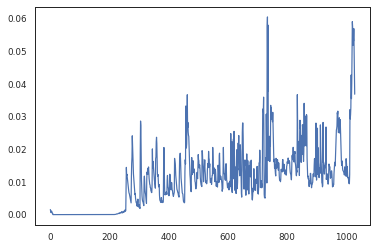

In [5]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
i=2
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
plt.plot(X[7910:8940])

Text(0, 0.5, 'rms value')

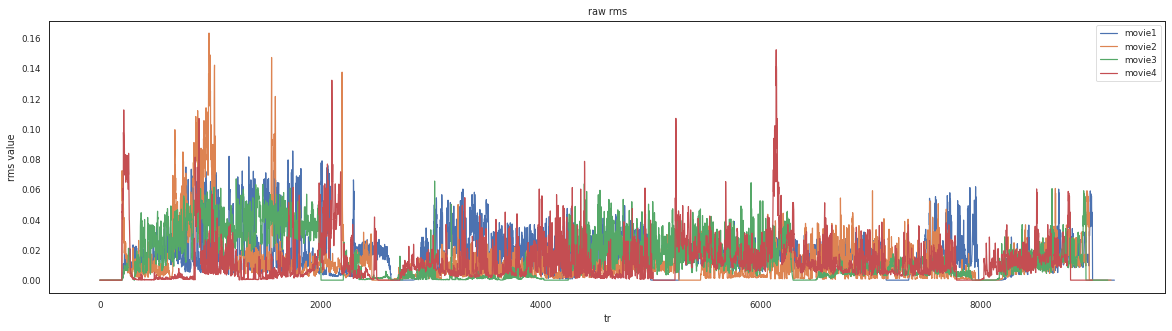

In [6]:
plt.figure(figsize=(20,5))
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    plt.plot(X, label=f'movie{str(i+1)}')
    plt.legend()
plt.title('raw rms')
plt.xlabel('tr')
plt.ylabel('rms value')

In [7]:
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
X.shape

(9011, 1)

Text(0.5, 0, 'tr')

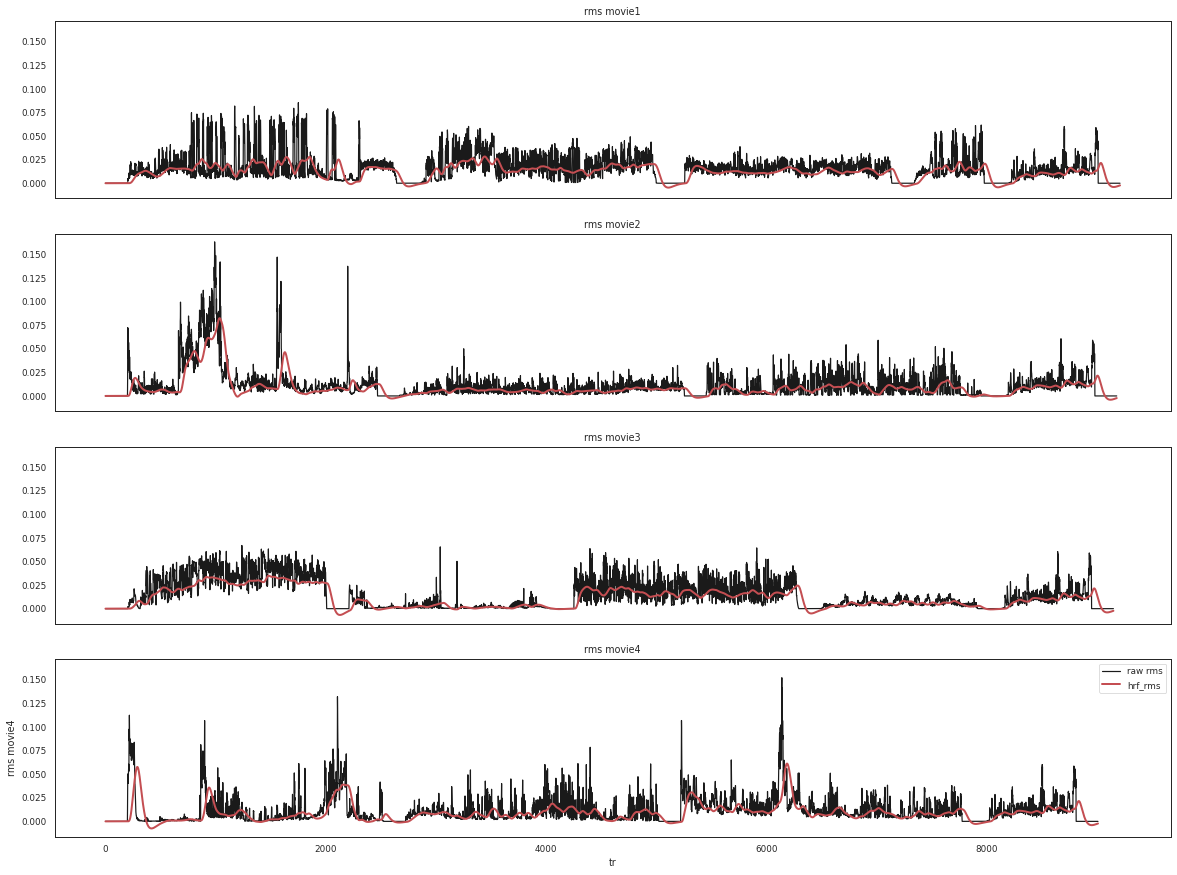

In [8]:
import hrf_tools
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    axs[i].plot(X, label=f'raw rms', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)
    axs[i].plot(X_hrf, label=f'hrf_rms', color='r', linewidth=2)
    plt.ylabel(f'rms movie{str(i+1)}')
    axs[i].set_title(f'rms movie{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')


In [9]:
X.shape

(9011, 1)

Text(0.5, 0, 'tr')

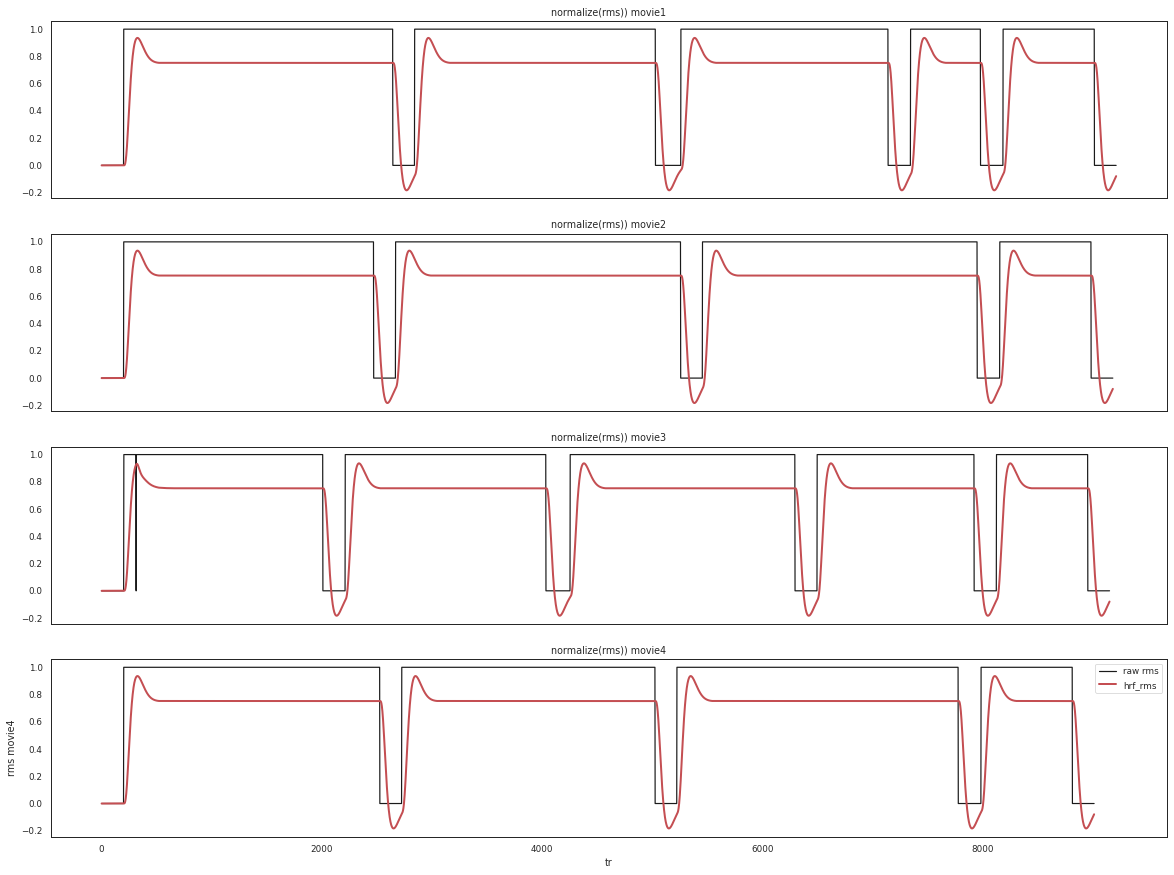

In [10]:
import hrf_tools
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    #X = scaler.fit_transform(X)
    #X = MinMaxScaler().fit_transform(X)
    X=normalize(X)
    #X=np.log10(X)
    #X = MinMaxScaler().fit_transform(X)
    axs[i].plot(X, label=f'raw rms', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)
    axs[i].plot(X_hrf, label=f'hrf_rms', color='r', linewidth=2)
    plt.ylabel(f'rms movie{str(i+1)}')
    axs[i].set_title(f'normalize(rms)) movie{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')

Text(0.5, 0, 'tr')

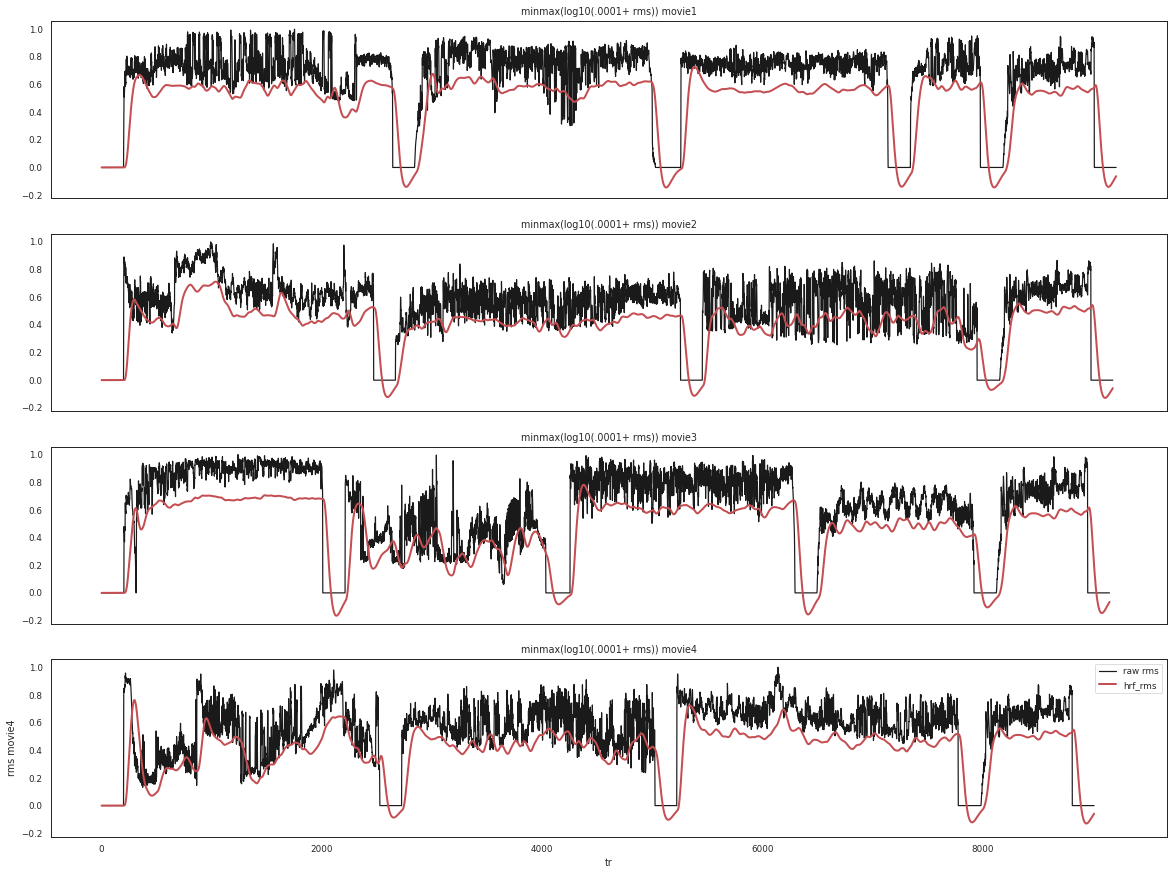

In [11]:
import hrf_tools
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    #X = scaler.fit_transform(X)
    #X = MinMaxScaler().fit_transform(X)
    X=X+0.0001
    X=np.log10(X)
    X = MinMaxScaler().fit_transform(X)
    axs[i].plot(X, label=f'raw rms', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)
    axs[i].plot(X_hrf, label=f'hrf_rms', color='r', linewidth=2)
    plt.ylabel(f'rms movie{str(i+1)}')
    axs[i].set_title(f'minmax(log10(.0001+ rms)) movie{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value
    plt.plot(X, label=f'movie{str(i+1)}')
    plt.legend()
plt.title('hrf convolved rms')
plt.xlabel('tr')
plt.ylabel('rms value')

NameError: name 'Y' is not defined

<Figure size 1440x360 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in np.arange(n_movies):
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    
    X = scaler.fit_transform(X)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value
    
    plt.plot(X, label=f'movie{str(i+1)}')
    plt.legend()
plt.title('standard scaled then hrf convolved rms')
plt.xlabel('tr')
plt.ylabel('rms value')

NameError: name 'Y' is not defined

<Figure size 1440x360 with 0 Axes>

In [14]:
np.hstack((X,X))

array([[ 0.        ,  0.        ],
       [-0.0051144 , -0.0051144 ],
       [-0.05165072, -0.05165072],
       ...,
       [-1.1293586 , -1.1293586 ],
       [-1.0990052 , -1.0990052 ],
       [-1.0687659 , -1.0687659 ]], dtype=float32)

In [15]:
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')

In [16]:
X.shape

(9211, 1)

In [50]:
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## run glm of basic RMS

In [35]:
import os
import analysis
import hrf_tools
import numpy as np
#import matplotlib
#matplotlib.rcParams['figure.figsize'] = (6, 4)
# this is run by run_datalad_run_encoding_model.sh
# "python ./run_encoding_model.py $sub $2"

#subject=100610
#open file
f = open('HCP_7T_subjects.txt', 'r')

#loop through each line and print
for line in f:
    subject=line.strip()

    feature='rms'
    dataset='HCP_7T'

    #temp_dir = '../../tmp'
    #if not os.path.exists(temp_dir):
    #    os.mkdir(temp_dir)

    n_movies=[1,2,3,4]

    #n_movies=[1]
    X,Y,vertex_info = analysis.load_data_HCP(subject,feature,n_movies)
    X = hrf_tools.apply_optimal_hrf_10hz(X,1)

    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

#     from nilearn.plotting import plot_design_matrix
#     plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    np.save(f'../outputs/glm/HCP_7T/rms/{subject}_all',contrast.z_score())

    plot_results(contrast.z_score(),'z','59k',vertex_info,subject,feature,'HCP_7T',f'glm_1_rms')

    #scores_mean,corr_mean,weights_mean = analysis.simple_ridgeCV(X,Y)

    #np.save(f'{temp_dir}/r2_{subject}_{feature}.npy',scores_mean)
    #np.save(f'{temp_dir}/r_{subject}_{feature}.npy',corr_mean)
    #np.save(f'{temp_dir}/w_{subject}_{feature}.npy',weights_mean)
    #analysis.plot_results(scores_mean,'z','59k',vertex_info,subject,feature,dataset,'glm')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data


/om2/vast/gablab/jsmentch/projects/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.18634687 0.19646588 0.20111449 ... 1.09026371 1.0975051  1.11084276]
[0.09724309 0.10361434 0.11299172 ... 1.10667351 1.11030089 1.11270221]
[0.18634687 0.19646588 0.20111449 ... 1.09026371 1.0975051  1.11084276]
[0.09724309 0.10361434 0.11299172 ... 1.10667351 1.11030089 1.11270221]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


FileNotFoundError: No such file or no access: '../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/102311/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'

## old way to run GLM

In [23]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
for i in np.arange(n_movies):
        
    im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y = img_y
    #Y = scaler.fit_transform(img_y)
    #load feature
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')

    X_n = normalize(X)
    X_n = hrf_tools.apply_optimal_hrf_10hz(X_n,10)
    X_n = hrf_tools.resample_1hz(X_n)
    X_n = X_n[:Y.shape[0],:] # if it has one extra value
    #X = scaler.fit_transform(X)
    X=X+0.0001
    X=np.log10(X)
    X = MinMaxScaler().fit_transform(X)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value

    X = np.hstack((X,X_n))
    
    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

    from nilearn.plotting import plot_design_matrix
    plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    np.save(f'../outputs/glm/HCP_7T/rms/{subject}_part{i}',contrast.z_score())

    plot_results(contrast.z_score(),'z','59k',vertex_info,subject,feature,'HCP_7T',f'glm_movie{i+1}_log10rms_includingnormalize_rawY')
    #plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_log10rms_includingnormalize_rawY')
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data


/om2/vast/gablab/jsmentch/projects/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.27140438 0.28489596 0.29151781 ... 0.75092021 0.76422264 0.78821548]
[0.28280865 0.2868098  0.28917106 ... 0.74103346 0.74778778 0.7500879 ]
[0.27140438 0.28489596 0.29151781 ... 0.75092021 0.76422264 0.78821548]
[0.28280865 0.2868098  0.28917106 ... 0.74103346 0.74778778 0.7500879 ]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data


/om2/vast/gablab/jsmentch/projects/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.30339802 0.31284385 0.31310348 ... 0.79288318 0.79344525 0.7949948 ]
[0.28963451 0.29088633 0.29967285 ... 0.79209773 0.80181564 0.80210536]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b25366f2310> (for post_execute):


KeyboardInterrupt: 

## Run AS-SPeech

In [10]:
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')

In [11]:
X_n.shape

NameError: name 'X_n' is not defined

In [12]:
X.shape

(1877, 521)

In [13]:
X_hrf.shape

(9011, 1)

In [14]:
from scipy.signal import resample

Text(0.5, 0, 'tr')

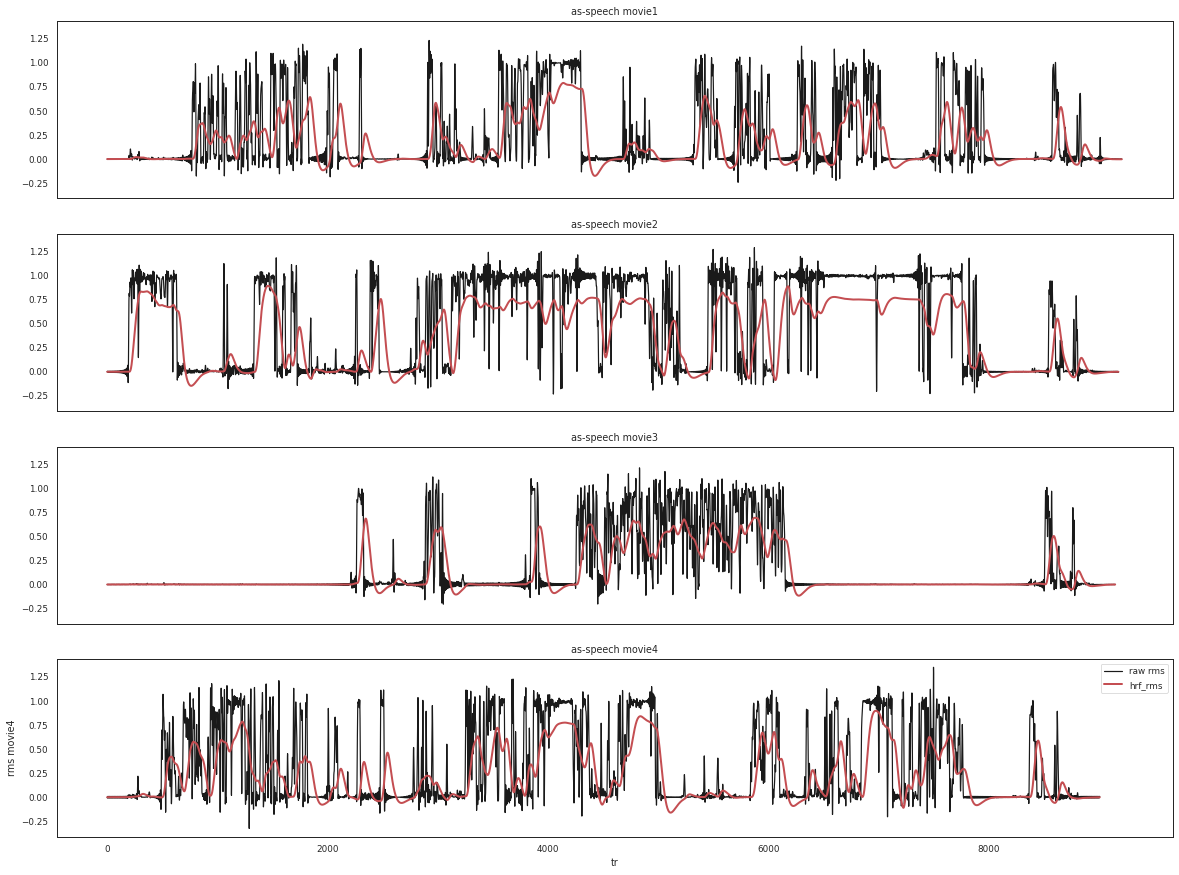

In [15]:
import hrf_tools
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(n_movies):
    X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,0:1]
    X=resample(X, X_shape)
    axs[i].plot(X, label=f'raw rms', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)   
    
    axs[i].plot(X_hrf, label=f'hrf_rms', color='r', linewidth=2)
    plt.ylabel(f'rms movie{str(i+1)}')
    axs[i].set_title(f'as-speech movie{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')


In [16]:
X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,0:1]
X=resample(X, X_shape)

In [21]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
for i in np.arange(n_movies):
        
    im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y = img_y
    #Y = scaler.fit_transform(img_y)
    #load feature
    
    X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,0:1]
    X=resample(X, X_shape)

#     X_n = normalize(X)
#     X_n = hrf_tools.apply_optimal_hrf_10hz(X_n,10)
#     X_n = hrf_tools.resample_1hz(X_n)
#     X_n = X_n[:Y.shape[0],:] # if it has one extra value
    #X = scaler.fit_transform(X)
#     X=X+0.0001
#     X=np.log10(X)
#     X = MinMaxScaler().fit_transform(X)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value

    #X = np.hstack((X,X_n))
    
    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

#     from nilearn.plotting import plot_design_matrix
#     plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    #plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_as-speech_rawY')
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')
    np.save(f'../outputs/glm/HCP_7T/as-speech/{subject}_part{i+1}',contrast.z_score())
    #gc.collect()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [19]:
plot_results(contrast.z_score(),'z','59k',vertex_info=vertex_info,subject=subject,feature='as-speech', dataset='HCP_7T',title=f'glm' )

Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data


/om2/vast/gablab/jsmentch/projects/nat_img/code/nilearn_plotting_custom.py:184: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(figure, rect=[0, 0, 1, 1],


[0.04504533 0.04777666 0.05921355 ... 1.25288816 1.26010501 1.26035035]
[-0.04070384  0.00412769  0.04577744 ...  1.24144858  1.2468949
  1.25351927]
[0.04504533 0.04777666 0.05921355 ... 1.25288816 1.26010501 1.26035035]
[-0.04070384  0.00412769  0.04577744 ...  1.24144858  1.2468949
  1.25351927]


## Run AS-Music

In [41]:
from scipy.signal import resample

Text(0.5, 0, 'tr')

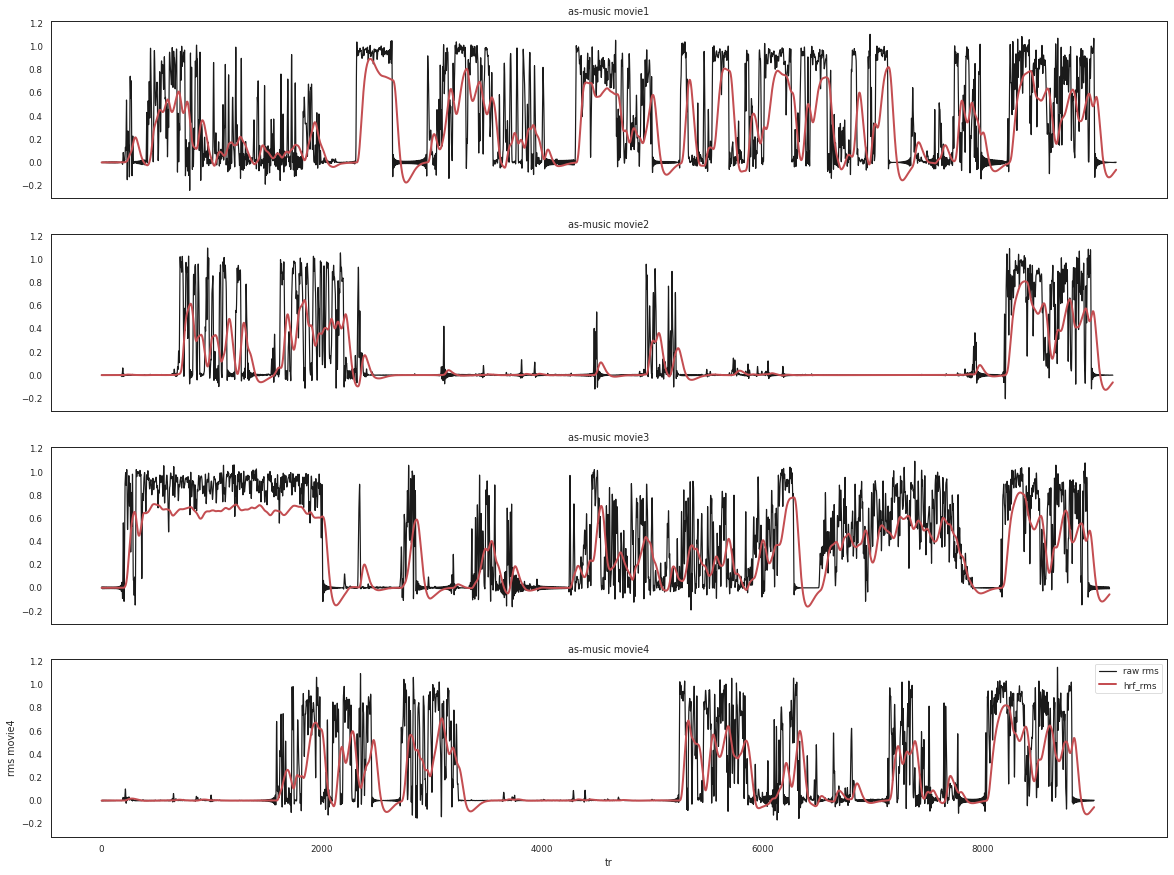

In [58]:
import hrf_tools
#plt.figure(figsize=(20,15))
# Share a Y axis with each row of subplots
fig, axs = plt.subplots(4, sharex=True, sharey=True,figsize=(20,15))
#fig.suptitle('Sharing both axes')
# axs[0].plot(x, y ** 2)
# axs[1].plot(x, 0.3 * y, 'o')
# axs[2].plot(x, y, '+')
for i in np.arange(n_movies):
    X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,132:133]
    X=resample(X, X_shape)
    axs[i].plot(X, label=f'raw rms', color = 'k')
    X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,10)   
    
    axs[i].plot(X_hrf, label=f'hrf_rms', color='r', linewidth=2)
    plt.ylabel(f'rms movie{str(i+1)}')
    axs[i].set_title(f'as-music movie{str(i+1)}')
plt.legend()
#plt.title('raw rms')
plt.xlabel('tr')


In [ ]:
X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,0:1]
X=resample(X, X_shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.13483189 0.16611534 0.19355511 ... 1.0527835  1.05875057 1.06117525]
[0.1976869  0.2192565  0.2200779  ... 0.95794521 0.97222862 0.97451193]
[0.13483189 0.16611534 0.19355511 ... 1.0527835  1.05875057 1.06117525]
[0.1976869  0.2192565  0.2200779  ... 0.95794521 0.97222862 0.97451193]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.19150352 0.19594414 0.19746544 ... 0.86814919 0.87015527 0.87147954]
[0.14185056 0.16188227 0.16980861 ... 0.87907985 0.88152247 0.8833166 ]
[0.19150352 0.19594414 0.19746544 ... 0.86814919 0.87015527 0.87147954]
[0.14185056 0.16188227 0.16980861 ... 0.87907985 0.88152247 0.8833166 ]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.16054536 0.19383017 0.19687989 ... 0.92977964 0.93776528 0.9407699 ]
[0.19202805 0.21177494 0.22731531 ... 0.97056317 0.98080241 0.98594012]
[0.16054536 0.19383017 0.19687989 ... 0.92977964 0.93776528 0.9407699 ]
[0.19202805 0.21177494 0.22731531 ... 0.97056317 0.98080241 0.98594012]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.20087684 0.21095086 0.21411027 ... 0.79957982 0.80167692 0.81233803]
[0.24392205 0.24656441 0.2518688  ... 0.81155163 0.81626545 0.81922624]
[0.20087684 0.21095086 0.21411027 ... 0.79957982 0.80167692 0.81233803]
[0.24392205 0.24656441 0.2518688  ... 0.81155163 0.81626545 0.81922624]


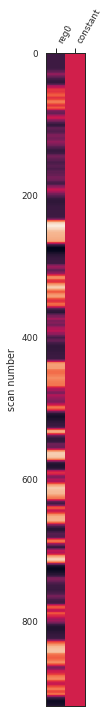

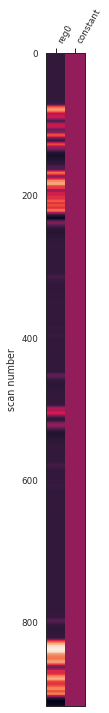

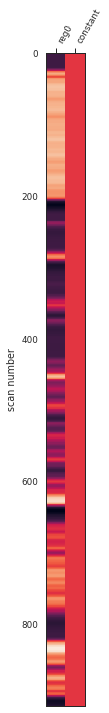

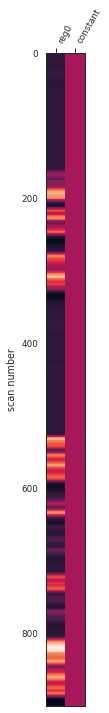

In [59]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
for i in np.arange(n_movies):
        
    im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y = img_y
    #Y = scaler.fit_transform(img_y)
    #load feature
    
    X_shape = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy').shape[0]
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_scores.npy')[:,132:133]
    X=resample(X, X_shape)

#     X_n = normalize(X)
#     X_n = hrf_tools.apply_optimal_hrf_10hz(X_n,10)
#     X_n = hrf_tools.resample_1hz(X_n)
#     X_n = X_n[:Y.shape[0],:] # if it has one extra value
    #X = scaler.fit_transform(X)
#     X=X+0.0001
#     X=np.log10(X)
#     X = MinMaxScaler().fit_transform(X)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value

    #X = np.hstack((X,X_n))
    
    n_scans = Y.shape[0]
    frame_times= np.arange(n_scans)

    from nilearn.glm.first_level import make_first_level_design_matrix
    design_matrix = make_first_level_design_matrix(frame_times, None,
                              add_regs=X, hrf_model=None, drift_model=None)

    from nilearn.plotting import plot_design_matrix
    plot_design_matrix(design_matrix)

    from nilearn.glm.first_level import run_glm
    labels,results = run_glm(Y,design_matrix.values)

    from nilearn.glm.contrasts import compute_contrast
    contrast = compute_contrast(labels=labels, \
                                regression_result=results, \
                                con_val=np.array([1,0]).T, \
                                contrast_type='t')
    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_as-music_rawY')
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

## Compare to Encoding model

In [11]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
from analysis import simple_ridgeCV

for i in [2,3]:
    im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y = scaler.fit_transform(img_y)
    #load feature
    X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
    X = scaler.fit_transform(X)
    X = hrf_tools.apply_optimal_hrf_10hz(X,10)
    X = hrf_tools.resample_1hz(X)
    X = X[:Y.shape[0],:] # if it has one extra value

    vertex_info = hcp.get_HCP_vertex_info(img)
    #from analysis import plot_59k_results
    
    scores_mean,corr_mean,weights_mean = simple_ridgeCV(X,Y)
    
    plot_59k_results(scores_mean,'r2',vertex_info,subject,feature,f'encoding_movie{i+1}_scaled')
    #plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
    #plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[-2.86305628 -2.69955414 -2.64854855 ...  1.54712941  1.54823802
  1.71944777]
[-2.43716498 -2.33481828 -2.10104274 ...  1.64543538  1.70068779
  1.74560489]
[-2.86305628 -2.69955414 -2.64854855 ...  1.54712941  1.54823802
  1.71944777]
[-2.43716498 -2.33481828 -2.10104274 ...  1.64543538  1.70068779
  1.74560489]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[-0.82762725 -0.80286727 -0.80096204 ...  0.93422081  0.94316647
  0.95820545]
[-0.80991465 -0.76027451 -0.75820489 ...  1.35267912  1.44147372
  1.53515266]
[-0.82762725 -0.80286727 -0.80096204 ...  0.93422081  0.94316647
  0.95820545]
[-0.80991465 -0.76027451 -0.75820489 ...  1.35267912  1.44147372
  1.53515266]


## Movie 2 looks bad. Lets look at just part 1 inception and the second part

In [2]:
subject=100610
feature='rms'
n_movies=4
scaler = StandardScaler()


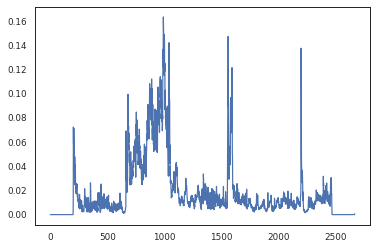

In [3]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
i=1
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
plt.plot(X[0:2670])

In [4]:
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y
#Y = scaler.fit_transform(img_y)
#load feature
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
X = scaler.fit_transform(X)
X = hrf_tools.apply_optimal_hrf_10hz(X,10)
X = hrf_tools.resample_1hz(X)
X = X[:Y.shape[0],:] # if it has one extra value



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### trim to just inception

In [5]:
X = X[0:267]
Y=Y[0:267]

In [6]:
n_scans = Y.shape[0]
frame_times= np.arange(n_scans)


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.28437985 0.29658238 0.30425344 ... 0.81589848 0.81799514 0.82070202]
[0.27195404 0.29538961 0.29887592 ... 0.82335969 0.82489803 0.82600334]
[0.28437985 0.29658238 0.30425344 ... 0.81589848 0.81799514 0.82070202]
[0.27195404 0.29538961 0.29887592 ... 0.82335969 0.82489803 0.82600334]


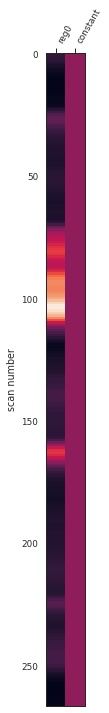

In [7]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times, None,
                          add_regs=X, hrf_model=None, drift_model=None)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

from nilearn.glm.first_level import run_glm
labels,results = run_glm(Y,design_matrix.values)

from nilearn.glm.contrasts import compute_contrast
contrast = compute_contrast(labels=labels, \
                            regression_result=results, \
                            con_val=np.array([1,0]).T, \
                            contrast_type='t')
vertex_info = hcp.get_HCP_vertex_info(img)
#from analysis import plot_59k_results
plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_part1_scaled_rawY')
#plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
#plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

## trim to just part 2


In [8]:
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y
#Y = scaler.fit_transform(img_y)
#load feature
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
X = scaler.fit_transform(X)
X = hrf_tools.apply_optimal_hrf_10hz(X,10)
X = hrf_tools.resample_1hz(X)
X = X[:Y.shape[0],:] # if it has one extra value



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [9]:
X = X[247:545]
Y=Y[247:545]

In [10]:
n_scans = Y.shape[0]
frame_times= np.arange(n_scans)


Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.22109521 0.22915634 0.2319511  ... 0.88848346 0.89062574 0.89346141]
[0.17310864 0.1849364  0.19262426 ... 0.87087631 0.87107491 0.87484617]
[0.22109521 0.22915634 0.2319511  ... 0.88848346 0.89062574 0.89346141]
[0.17310864 0.1849364  0.19262426 ... 0.87087631 0.87107491 0.87484617]


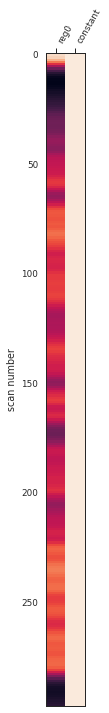

In [11]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times, None,
                          add_regs=X, hrf_model=None, drift_model=None)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

from nilearn.glm.first_level import run_glm
labels,results = run_glm(Y,design_matrix.values)

from nilearn.glm.contrasts import compute_contrast
contrast = compute_contrast(labels=labels, \
                            regression_result=results, \
                            con_val=np.array([1,0]).T, \
                            contrast_type='t')
vertex_info = hcp.get_HCP_vertex_info(img)
#from analysis import plot_59k_results
plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_part2_scaled_rawY')
#plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
#plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')

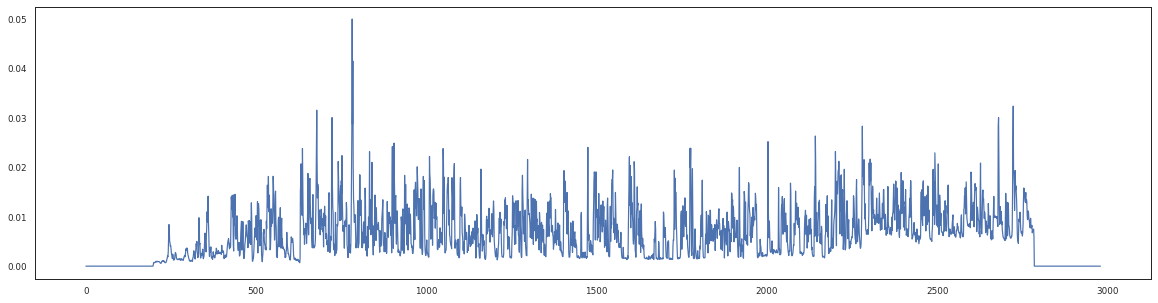

In [15]:
plt.figure(figsize=(20,5))
X_orig = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
plt.plot(X_orig[2470:5450])

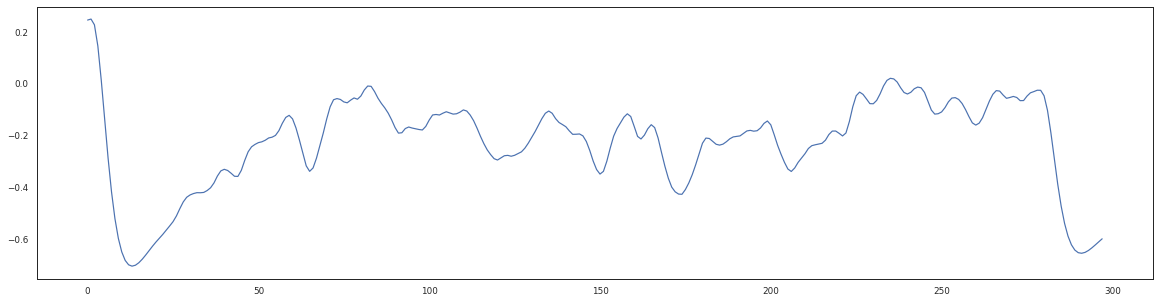

In [16]:
plt.figure(figsize=(20,5))
plt.plot(X)

## now do just part 3

In [4]:
subject=100610
feature='rms'
n_movies=4
scaler = StandardScaler()


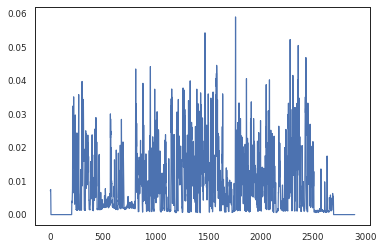

In [6]:
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
i=1
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
plt.plot(X[5250:8150])

In [7]:
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y
#Y = scaler.fit_transform(img_y)
#load feature
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
X = scaler.fit_transform(X)
X = hrf_tools.apply_optimal_hrf_10hz(X,10)
X = hrf_tools.resample_1hz(X)
X = X[:Y.shape[0],:] # if it has one extra value



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### trim to just part 3

In [8]:
X = X[525:815]
Y=Y[525:815]

In [9]:
n_scans = Y.shape[0]
frame_times= np.arange(n_scans)


ERROR! Session/line number was not unique in database. History logging moved to new session 1338
Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.28064203 0.28318534 0.28957313 ... 1.0595352  1.06163147 1.0716312 ]
[0.27699553 0.28163195 0.29191418 ... 1.1002773  1.10747904 1.11626129]
[0.28064203 0.28318534 0.28957313 ... 1.0595352  1.06163147 1.0716312 ]
[0.27699553 0.28163195 0.29191418 ... 1.1002773  1.10747904 1.11626129]


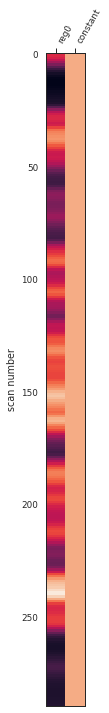

In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times, None,
                          add_regs=X, hrf_model=None, drift_model=None)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

from nilearn.glm.first_level import run_glm
labels,results = run_glm(Y,design_matrix.values)

from nilearn.glm.contrasts import compute_contrast
contrast = compute_contrast(labels=labels, \
                            regression_result=results, \
                            con_val=np.array([1,0]).T, \
                            contrast_type='t')
vertex_info = hcp.get_HCP_vertex_info(img)
#from analysis import plot_59k_results
plot_59k_results(contrast.z_score(),'z',vertex_info,subject,feature,f'glm_movie{i+1}_part3_scaled_rawY')
#plot_59k_results(contrast.p_value(),'p',vertex_info,subject,feature,'glm1run_p')
#plot_59k_results(contrast.effect_size(),'d',vertex_info,subject,feature,'glm1run_d')